In [18]:
# Helpers
import pickle
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt

# DB 
import psycopg2
from django.conf import settings

# Learning
from spkit import bkt

# Evaluation
from sklearn.metrics import roc_curve, auc, f1_score, confusion_matrix

In [2]:
folder = "data/edm2020"
N_RUNS = 10

### Organizing data

In [74]:
def add_to_list(data, attempts=None):
    cleaned_data = []
    for item in data:
        s_idx, q_idx, a_idx, outcome = item
        if attempts and a_idx >= attempts:
            continue
        cleaned_data.append([outcome, s_idx, q_idx])
    return cleaned_data
    
def transform_data(data):
    student_performance = add_to_list(data['train_set'], 150)
    student_performance_test = add_to_list(data['test_set'])
    return student_performance, student_performance_test

In [75]:
def run(*args):
    dataset, student_performance, student_performance_test, q_matrix, students = args
    
    # Run BKT
    start = time.time()
    model = bkt.BKT()
    model.fit(student_performance, q_matrix)
    end = time.time()
    
    data_arr = np.asarray(student_performance)
    rmse = 0
    n = 0
    score_df = []
    learning_state = {}
    y = []
    y_pred = []
    
    # Predict for each training student
    for student in range(len(students)):
        student_idx = np.where(data_arr[:,1] == student)
        outcome = data_arr[student_idx, 0].astype('int64')
        y += outcome.tolist()[0]
        question_id = data_arr[student_idx, 2].astype('int64')
        data_student = np.vstack((outcome, question_id)).T.astype('int64').tolist()
        predicted = model.predict_proba(data_student, q_matrix)
        y_pred += predicted[:,1].tolist()
        s_ll, s_aic, s_bic, s_rmse, s_acc = model.score()
        try:
            fpr, tpr, _ = roc_curve(outcome.flatten(), predicted[:,1], pos_label=1)
            auc_score = auc(fpr, tpr)
        except ValueError:
            print("auc error found")
            auc_score = 0
        score_df.append({"student": student,
                         "AIC": s_aic,
                         "BIC": s_bic,
                         "RMSE": s_rmse,
                         "Acc": s_acc,
                         "n questions": model.n_questions,
                         "LL": s_ll,
                         "correct_outcome": np.where(outcome == 1)[1].shape[0],
                         "incorrect_outcome": np.where(outcome == 0)[1].shape[0],
                         "AUC": auc_score})
        learning_state[student] = model.get_learning_state()
    # Calculate train metrics
    score = pd.DataFrame.from_dict(score_df)
    rmse_train = np.sqrt((score['RMSE']**2*score['n questions']).sum()/score['n questions'].sum())
    print(rmse_train)
    acc_train = (score['Acc']*score['n questions']).sum()/score['n questions'].sum()
    y = np.asarray(y)
    y_pred = np.asarray(y_pred)
    
    try:
        fpr, tpr, thresholds = roc_curve(y, y_pred, pos_label=1)
        auc_score = auc(fpr, tpr)
    except ValueError:
        auc_score = 0
        tpr = fpr = [0]
        acc = 0
        f1 = 0
        y_pred_binary = [0]
        J_opt_thresholds = 0
    else:
        J_stats = tpr - fpr
        J_opt_thresholds = thresholds[np.argmax(J_stats)]
        print('Youden\'s optimum threshold: %.2f' % J_opt_thresholds)
        y_pred_binary = np.where(y_pred > J_opt_thresholds, 1, 0)
        acc = (y_pred_binary == y).sum()/score['n questions'].sum()
        f1 = f1_score(y, y_pred_binary)
        plt.figure()
        lw = 2
        plt.plot(fpr, tpr, color='darkorange',
                 lw=lw, label='ROC curve (area = %0.2f)' % auc_score)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic example')
        plt.legend(loc="lower right")
        plt.show()
        print(print(confusion_matrix(y,y_pred_binary)))

    row = {
        "dataset": "run_%d" % dataset,
        "q_matrix": q_matrix,
        "sp": student_performance,
        "sp_test": student_performance_test,
        "sp_hat": y_pred,
        "sk_hat": learning_state,
        "q_matrix_hat": q_matrix,
        "concepts": 14,
        "method": "bkt",
        "q_matrix_error": 0,
        "seconds": end-start,
        "train_auc": auc_score,
        "train_acc": acc,
        "train_rmse": rmse_train,
        "auc_threshold": J_opt_thresholds,
        "train_1":  np.where(y == 1)[0].shape[0],
        "train_0":  np.where(y == 0)[0].shape[0],
#         "train_pred_1": np.where(y_pred_binary == 1)[0].shape[0],
#         "train_pred_0": np.where(y_pred_binary == 0)[0].shape[0],
        "train_f1": f1,
#         "train_nll": nll,
#         "train_nll_special": nll_special,
#         "train_nll_masked": idx[0].shape[0],
#         "train_rmse_1": rmse_1,
#         "train_rmse_0": rmse_0
    }
    return row

    # Write PSQL query
#     insert_query_base = "INSERT INTO EDM2020_2020_02_19 "
#     column_value = []
#     insert_format = []
#     query_values = []
#     for col in row.keys():
#         if isinstance(row[col], np.ndarray):
#             query_values.append(row[col].tolist())
#         else:
#             query_values.append(row[col])
#         column_value.append(col)
#         insert_format.append("%s")

#     insert_query = insert_query_base + "(" + ", ".join(column_value) + ") VALUES "
#     insert_query += "(" + ", ".join(insert_format) + ")"
#     query_values = tuple(query_values)
#     query = cursor.mogrify(insert_query, query_values)
#     cursor.execute(query)

In [76]:
args = []
for restart in range(1):
    for dataset in range(N_RUNS):
        with open("%s/2020_06_08_run_%d.pkl" % (folder, dataset), "rb") as pklfile:
            data = pickle.load(pklfile)
            train_set, test_set = transform_data(data)
            args.append([dataset, 
                        train_set, 
                        test_set,
                        data['q_matrix'].T,
                        data['users_idx']])

In [77]:
next_id = 0

0.39894957564472017
Youden's optimum threshold: 0.13


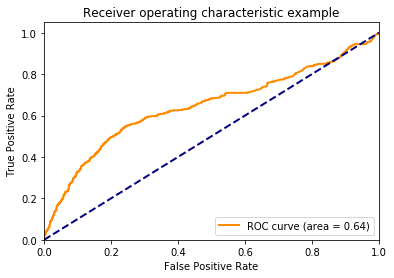

[[1788  578]
 [ 294  357]]
None
0.39781997333225183
Youden's optimum threshold: 0.13


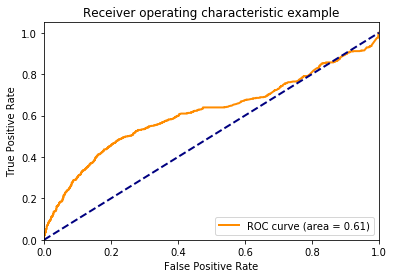

[[1783  510]
 [ 314  293]]
None
0.3968075393792544
Youden's optimum threshold: 0.12


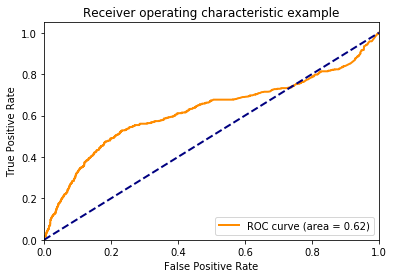

[[1814  552]
 [ 297  331]]
None
0.3950514452469489
Youden's optimum threshold: 0.12


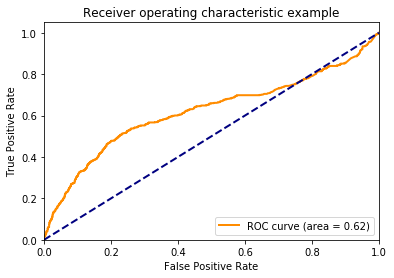

[[1843  557]
 [ 305  318]]
None
0.40201578380652603
Youden's optimum threshold: 0.16


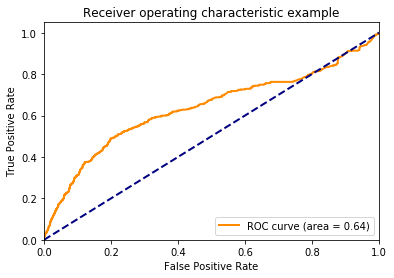

[[1873  467]
 [ 336  321]]
None
0.3967567712263074
Youden's optimum threshold: 0.12


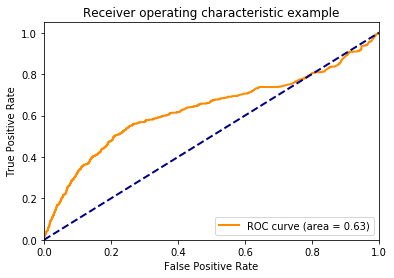

[[1839  623]
 [ 299  361]]
None
0.4071342858913286
Youden's optimum threshold: 0.13


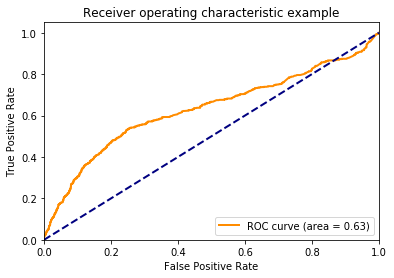

[[1674  575]
 [ 300  351]]
None
0.4008014848719282
Youden's optimum threshold: 0.14


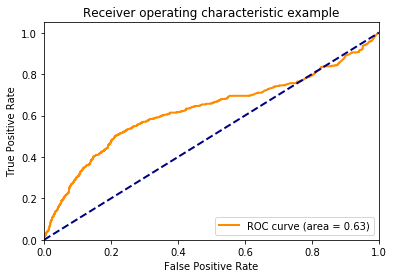

[[1884  511]
 [ 325  328]]
None
0.39952963174300193
Youden's optimum threshold: 0.12


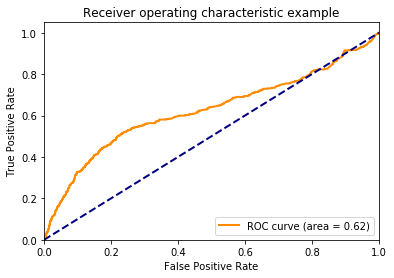

[[1783  557]
 [ 304  328]]
None
0.40172919165776566
Youden's optimum threshold: 0.12


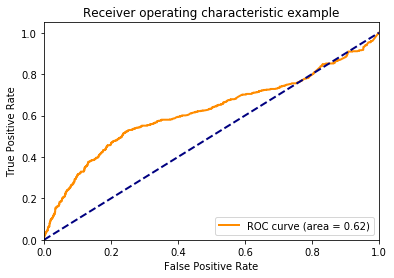

[[1734  559]
 [ 300  326]]
None
CPU times: user 5.89 s, sys: 155 ms, total: 6.05 s
Wall time: 7.64 s


In [78]:
%%time
connection = psycopg2.connect(user = settings.DATABASES["default"]["USER"],
                                  password = settings.DATABASES["default"]["PASSWORD"],
                                  host = settings.DATABASES["default"]["HOST"],
                                  port = settings.DATABASES["default"]["PORT"],
                                  database = settings.DATABASES["default"]["NAME"])
connection.autocommit=True
cursor = connection.cursor()

for item in args[next_id:]:
    row = run(*item)

In [60]:
for key in row.keys():
    if 'train' in key:
        print("%s: %.2f" % (key, row[key]))

train_auc: 0.55
train_acc: 0.70
train_rmse: 0.41
train_1: 435.00
train_0: 1544.00
train_pred_1: 492.00
train_pred_0: 1487.00
train_f1: 0.37
